In [4]:
!pip install tensorflow

In [1]:
!pip install segmentation_models

In [5]:
import os
import numpy as np
import tensorflow as tf
import segmentation_models as sm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 1. Set parameters
BACKBONE = 'resnet34'
CLASSES = ['bare_land', 'forest', 'water']  # Your classes
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE = (256, 256)  # Resize images & masks to this size

# 2. Get preprocessing function for backbone
preprocess_input = sm.get_preprocessing(BACKBONE)

In [7]:
preprocess_input

<function classification_models.models.resnet.preprocess_input(x, **kwargs)>

In [9]:
# 3. Load images and masks from folders (replace paths accordingly)
def load_data(image_dir, mask_dir):
    images = []
    masks = []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        # Load image
        img_path = os.path.join(image_dir, img_file)
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img)

        # Load mask (assumed grayscale with integer labels)
        mask_path = os.path.join(mask_dir, mask_file)
        mask = load_img(mask_path, color_mode='grayscale', target_size=IMAGE_SIZE)
        mask = img_to_array(mask).squeeze().astype(np.uint8)  # shape: (H, W)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Example paths (update these)
image_dir = '/content/drive/MyDrive/Image_Segmentation_DL/landcover.ai.v0/images'
mask_dir = '/content/drive/MyDrive/Image_Segmentation_DL/landcover.ai.v0/masks'


In [10]:
images, masks = load_data(image_dir, mask_dir)

In [18]:
# print(masks[1])

In [21]:
# 4. Preprocess input images for backbone
images = preprocess_input(images)

# Check unique values in masks before one-hot encoding
unique_mask_values, counts = np.unique(masks, return_counts=True)
print("Unique mask values and their counts:", dict(zip(unique_mask_values, counts)))

# 5. Convert masks to one-hot encoding for multi-class segmentation
# Ensure that the mask values are within the range [0, NUM_CLASSES - 1]
# If the unique mask values printout shows values outside this range,
# you need to investigate the source of your mask data or preprocess it
# to correct the labels.

# Filter masks to keep only values less than NUM_CLASSES
# This is a quick fix. A better approach is to understand why value 3 exists
# and handle it appropriately (e.g., remap or include as a separate class).
masks_filtered = np.where(masks < NUM_CLASSES, masks, 0) # Replace values >= NUM_CLASSES with 0

masks_cat = to_categorical(masks_filtered, num_classes=NUM_CLASSES)  # shape (N, H, W, classes)

# Verify unique values in the filtered masks
unique_mask_values_filtered, counts_filtered = np.unique(masks_filtered, return_counts=True)
print("Unique mask values and their counts after filtering:", dict(zip(unique_mask_values_filtered, counts_filtered)))

Unique mask values and their counts: {np.uint8(0): np.int64(1521340), np.uint8(1): np.int64(28556), np.uint8(2): np.int64(943770), np.uint8(3): np.int64(193310)}
Unique mask values and their counts after filtering: {np.uint8(0): np.int64(1714650), np.uint8(1): np.int64(28556), np.uint8(2): np.int64(943770)}


In [25]:
#masks_cat

In [26]:
# 6. Split data
X_train, X_val, y_train, y_val = train_test_split(images, masks_cat, test_size=0.2, random_state=42)

In [74]:
#y_train

In [29]:
# 7. Build model
model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
    classes=NUM_CLASSES,
    activation='softmax'
)
model


85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


<Functional name=functional_1, built=True>

In [30]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,456,444 (93.29 MB)

 Trainable params: 24,439,094 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [31]:
model.compile(
    'adam',
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)]
)

In [78]:
# 8. Train model
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=12,
    epochs=30
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 83s 19s/step - loss: 0.2891 - mean_io_u: 0.3333 - val_loss: 0.6599 - val_mean_io_u: 0.3333
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 84s 22s/step - loss: 0.2788 - mean_io_u: 0.3333 - val_loss: 0.7220 - val_mean_io_u: 0.3333
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 61s 20s/step - loss: 0.2785 - mean_io_u: 0.3333 - val_loss: 0.7221 - val_mean_io_u: 0.3333
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 19s/step - loss: 0.2755 - mean_io_u: 0.3333 - val_loss: 0.6724 - val_mean_io_u: 0.3333
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 19s/step - loss: 0.2625 - mean_io_u: 0.3333 - val_loss: 0.6073 - val_mean_io_u: 0.3333
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 19s/step - loss: 0.2557 - mean_io_u: 0.3333 - val_loss: 0.5870 - val_mean_io_u: 0.3333
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 59s 19s/step - loss: 0.2898 - mean_io_u: 0.3333 - val_loss: 0.6040 - val_mean_io_u: 0.3333
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 59s 19s/step - loss: 0.2623 - mean_io_u: 0.3333 - val_loss: 0.5842 - val_me

In [79]:
# Predict masks for validation images
y_pred = model.predict(X_val)  # shape: (num_samples, H, W, num_classes)
#y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [80]:
y_pred_labels = np.argmax(y_pred, axis=-1)  # shape: (num_samples, H, W)
y_pred_labels[0]

array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 2, 0, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [0, 2, 2, ..., 0, 0, 0],
       [2, 0, 2, ..., 0, 0, 0]])

In [81]:
y_true_labels = np.argmax(y_val, axis=-1)  # shape: (num_samples, H, W)
y_true_labels[0]

array([[0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 2, 2, 0],
       [0, 0, 0, ..., 2, 2, 0],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]])

In [82]:
# Pixel-wise accuracy example
accuracy = np.mean(y_pred_labels == y_true_labels)
print("Pixel Accuracy:", accuracy)

# If you want to compute Mean IoU with TensorFlow:
miou_metric = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)
miou_metric.update_state(y_true_labels.flatten(), y_pred_labels.flatten())
print("Mean IoU:", miou_metric.result().numpy())


Pixel Accuracy: 0.8185373942057291
Mean IoU: 0.45924613


In [ ]:
#building (1), woodland (2), water (3), and road (4)

# Visualizing outputed Images

In [75]:
# # Predict
# y_pred = model.predict(X_val)
# y_pred_labels = np.argmax(y_pred, axis=-1)
# y_true_labels = np.argmax(y_val, axis=-1)

# # Accuracy
# accuracy = np.mean(y_pred_labels == y_true_labels)
# print("Pixel Accuracy:", accuracy)

# # Mean IoU
# miou_metric = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)
# miou_metric.update_state(y_true_labels.flatten(), y_pred_labels.flatten())
# print("Mean IoU:", miou_metric.result().numpy())

# # Visualize
# plot_sample(X_val[0], y_true_labels[0], y_pred_labels[0])

# # Option 1: If float values are too high, scale to [0,1]
# image_vis = X_val[3] / 255.0
# plt.imshow(image_vis)

# # Option 2: Convert to uint8 if appropriate
# image_vis = X_val[3].astype(np.uint8)
# plt.imshow(image_vis)

In [83]:
# Define class colors and labels
CLASS_COLORS = {
    0: (0, 0, 0),           # Background - Black
    1: (255, 0, 0),         # Building - Red
    2: (0, 255, 0),         # Woodland - Green
    3: (0, 0, 255),         # Water - Blue
    4: (128, 128, 128),     # Road - Gray
}

CLASS_LABELS = {
    0: "Background",
    1: "Building",
    2: "Woodland",
    3: "Water",
    4: "Road"
}

# Convert integer mask to RGB image
def colorize_mask(mask, class_colors):
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        color_mask[mask == class_id] = color
    return color_mask

In [98]:
# Example: one sample
# change index to any example you want to visualize
idx = 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


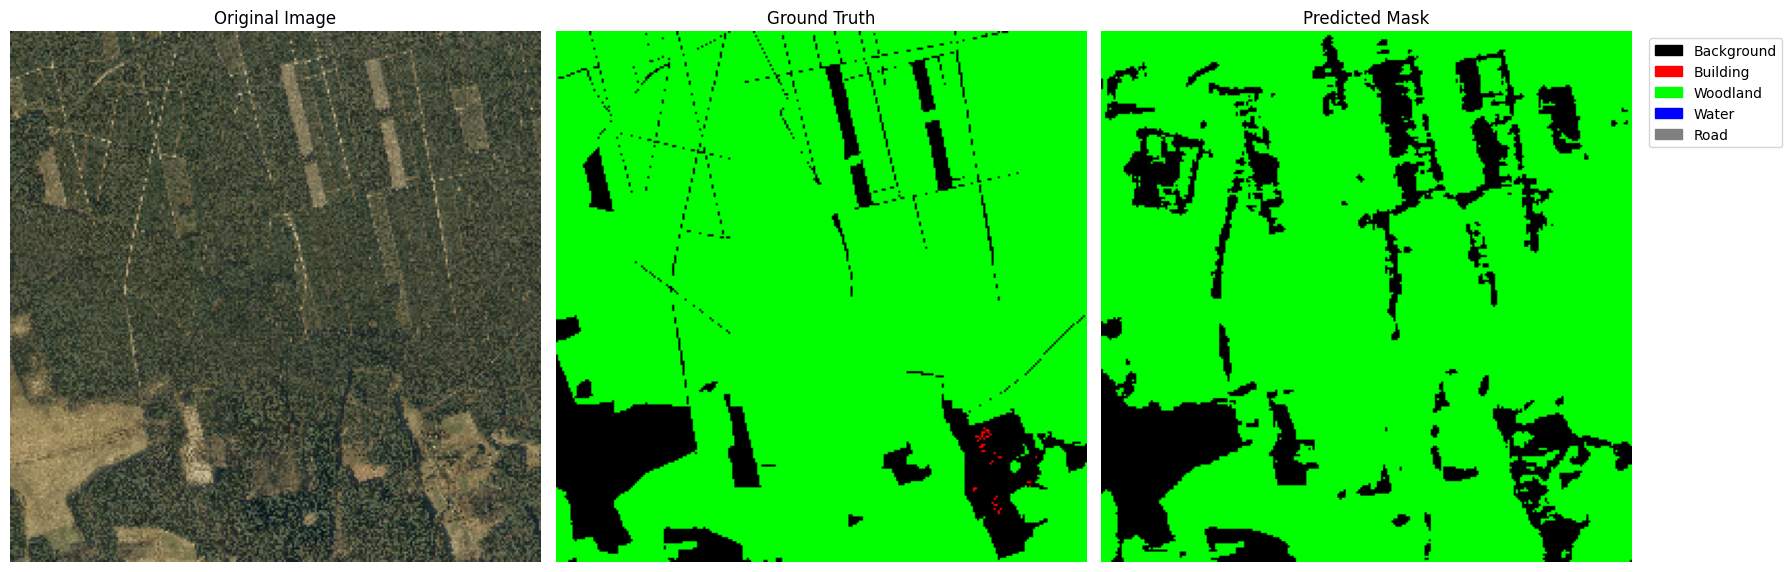

In [99]:
# Original image (normalize for display if necessary)
image = X_val[idx].astype(np.uint8)  # If already [0–255]
# If preprocessed to [-1,1] or other range, rescale:
# image = ((X_val[idx] + 1) * 127.5).astype(np.uint8)

# True and predicted labels (argmax from one-hot encoded)
y_true_labels = np.argmax(y_val, axis=-1)
y_pred_labels = np.argmax(model.predict(X_val), axis=-1)

true_mask_rgb = colorize_mask(y_true_labels[idx], CLASS_COLORS)
pred_mask_rgb = colorize_mask(y_pred_labels[idx], CLASS_COLORS)

# Plot original + masks
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(true_mask_rgb)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask_rgb)
plt.axis('off')

# Create legend
legend_patches = [
    mpatches.Patch(color=np.array(color)/255.0, label=CLASS_LABELS[class_id])
    for class_id, color in CLASS_COLORS.items()
]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()